## Feature Selection Methods: 

This notebook is experimenting feature selection for Reading subject Learning Loss with methods such as:
- Variance Threshold
- L1 Regularization (Lasso)
- Random Forest Feature Importance 
- Permutation Importance
    - with Random Forest
    - with Ridge Regression
- Recursive Feature Elimination (RFE)
    - with Random Forest
    - with Ridge Regression
- Sequential Feature Selection (SFS)
    - with KNN
    - with Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

**Loading Data**

Cleaned and integrated from [Data_Integration.ipynb](Data_Integration.ipynb)

In [3]:
df = pd.read_csv('DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']

cols_drop = ['% Tested Math G3 Diff',
            '% Tested Math G4 Diff',
            '% Tested Math G5 Diff',
            '% Tested Math G6 Diff',
            '% Tested Math G7 Diff',
            '% Tested Math G8 Diff',
            'District #', 'County #']

y = df['Label_Reading'].values
X = df.drop(columns=labels + cols_drop).values
columns = df.drop(columns=labels + cols_drop).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=123, shuffle=True)
print(X.shape)

(955, 90)


**Normalization**

In [6]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
random_state=123
results = pd.DataFrame()

### Variance Threshold ###

In [8]:
from sklearn.feature_selection import VarianceThreshold

# dropping columns where 1-threshold of the values are similar
# a feature contains only 0s 80% of the time or only 1s 80% of the time
sel = VarianceThreshold(threshold=.8*(1-.8))

sel.fit_transform(X)
selected_var = columns[sel.get_support()]

temp = pd.DataFrame({'feature': selected_var.to_list(),
                     'method': 'Variance Threshold',
                     'model': 'n/a',
                     'importance': 1})
results = pd.concat([results, temp], ignore_index=True)

print('n_features_selected:',selected_var.shape[0])
print('Features Selected: ', selected_var)

n_features_selected: 20
Features Selected:  Index(['Unemployed Level Diff', 'Median Age 10', 'Median Age Male 10',
       'Median Age Female 10', '# of Households 10', 'Avg Household Size 10',
       '# of Families 10', 'Avg Family Size 10', '# of Housing Units 10',
       'County Population', 'CARES ESSER I 20', 'CRRSA ESSER II 21',
       'ARP ESSER III 21', 'ESSER-SUPP 22', 'ESSER-SUPP 23',
       '% Reduced-price Lunch Diff', '% Asian Diff', '% Black Diff',
       '% Prek Diff', 'Locale_42-Rural: Distant'],
      dtype='object')


### L1(Lasso) Regularization ###

In [9]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, multi_class='ovr', random_state=random_state)
lasso.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(lasso.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(lasso.score(X_test, y_test)))

df_lasso = pd.DataFrame()

for c, cla in zip(lasso.coef_, range(-2,3,1)):
    temp = pd.DataFrame({'feature': columns, 'coef': c, 'class': cla})
    df_lasso = pd.concat([df_lasso, temp], ignore_index=True)

df_lasso2 = df_lasso.groupby(['feature'], as_index=False).agg({'coef': 'sum'})
df_lasso2['Model'] = 'Lasso'

df_lasso3 = df_lasso2[df_lasso2['coef']!=0].copy()
df_lasso3['importances'] = 1
temp = pd.DataFrame({'feature': df_lasso3['feature'], 
                        'method': 'Regularization',
                        'model': 'Lasso', 
                        'importance': df_lasso3['importances']})
results = pd.concat([results, temp], ignore_index=True)

Train Accuracy: 0.60
Test Accuracy: 0.58


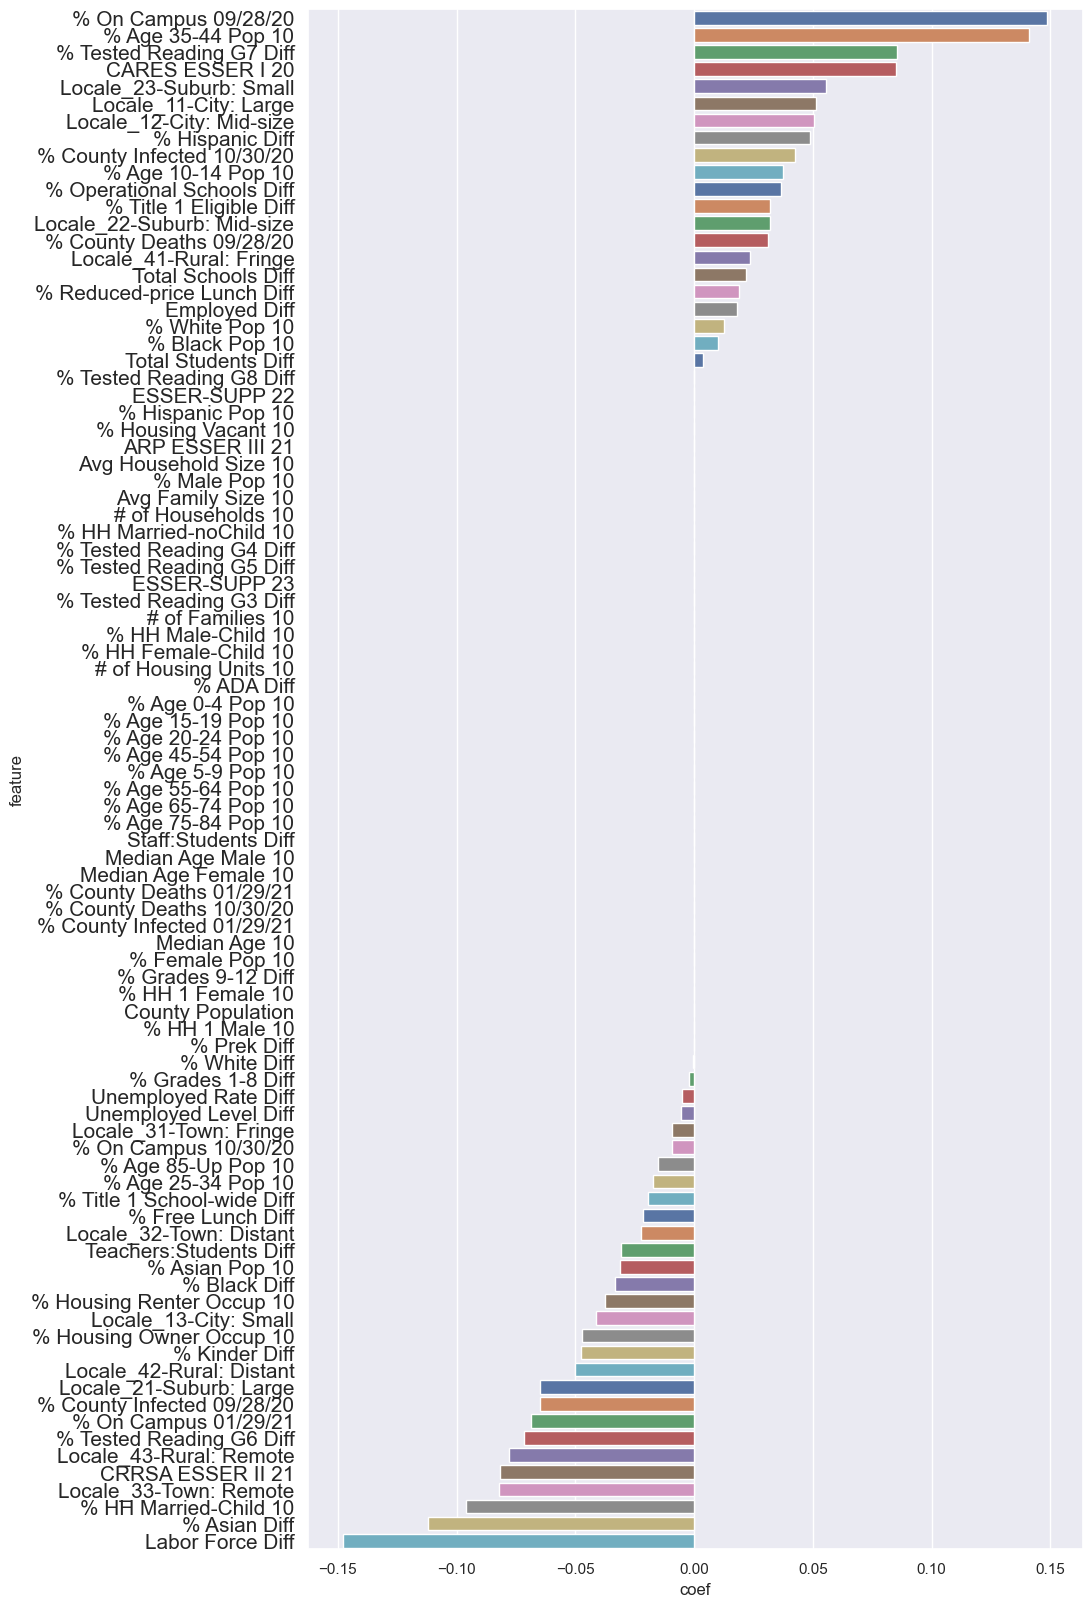

In [10]:
df_lasso2 = df_lasso2.sort_values(by=['coef'], ascending=False)
sns.set(rc={'figure.figsize':(10, 20)})
g=sns.barplot(data=df_lasso2, y="feature", x="coef", palette="deep", orient="h")
# g.set_xticklabels(g.get_xticklabels(), rotation=90, size=20)
g.set_yticklabels(g.get_yticklabels(), size=15)
plt.show()

### Random Forest Feature Importance ###

Train Score: 1.00
Test Score: 0.53


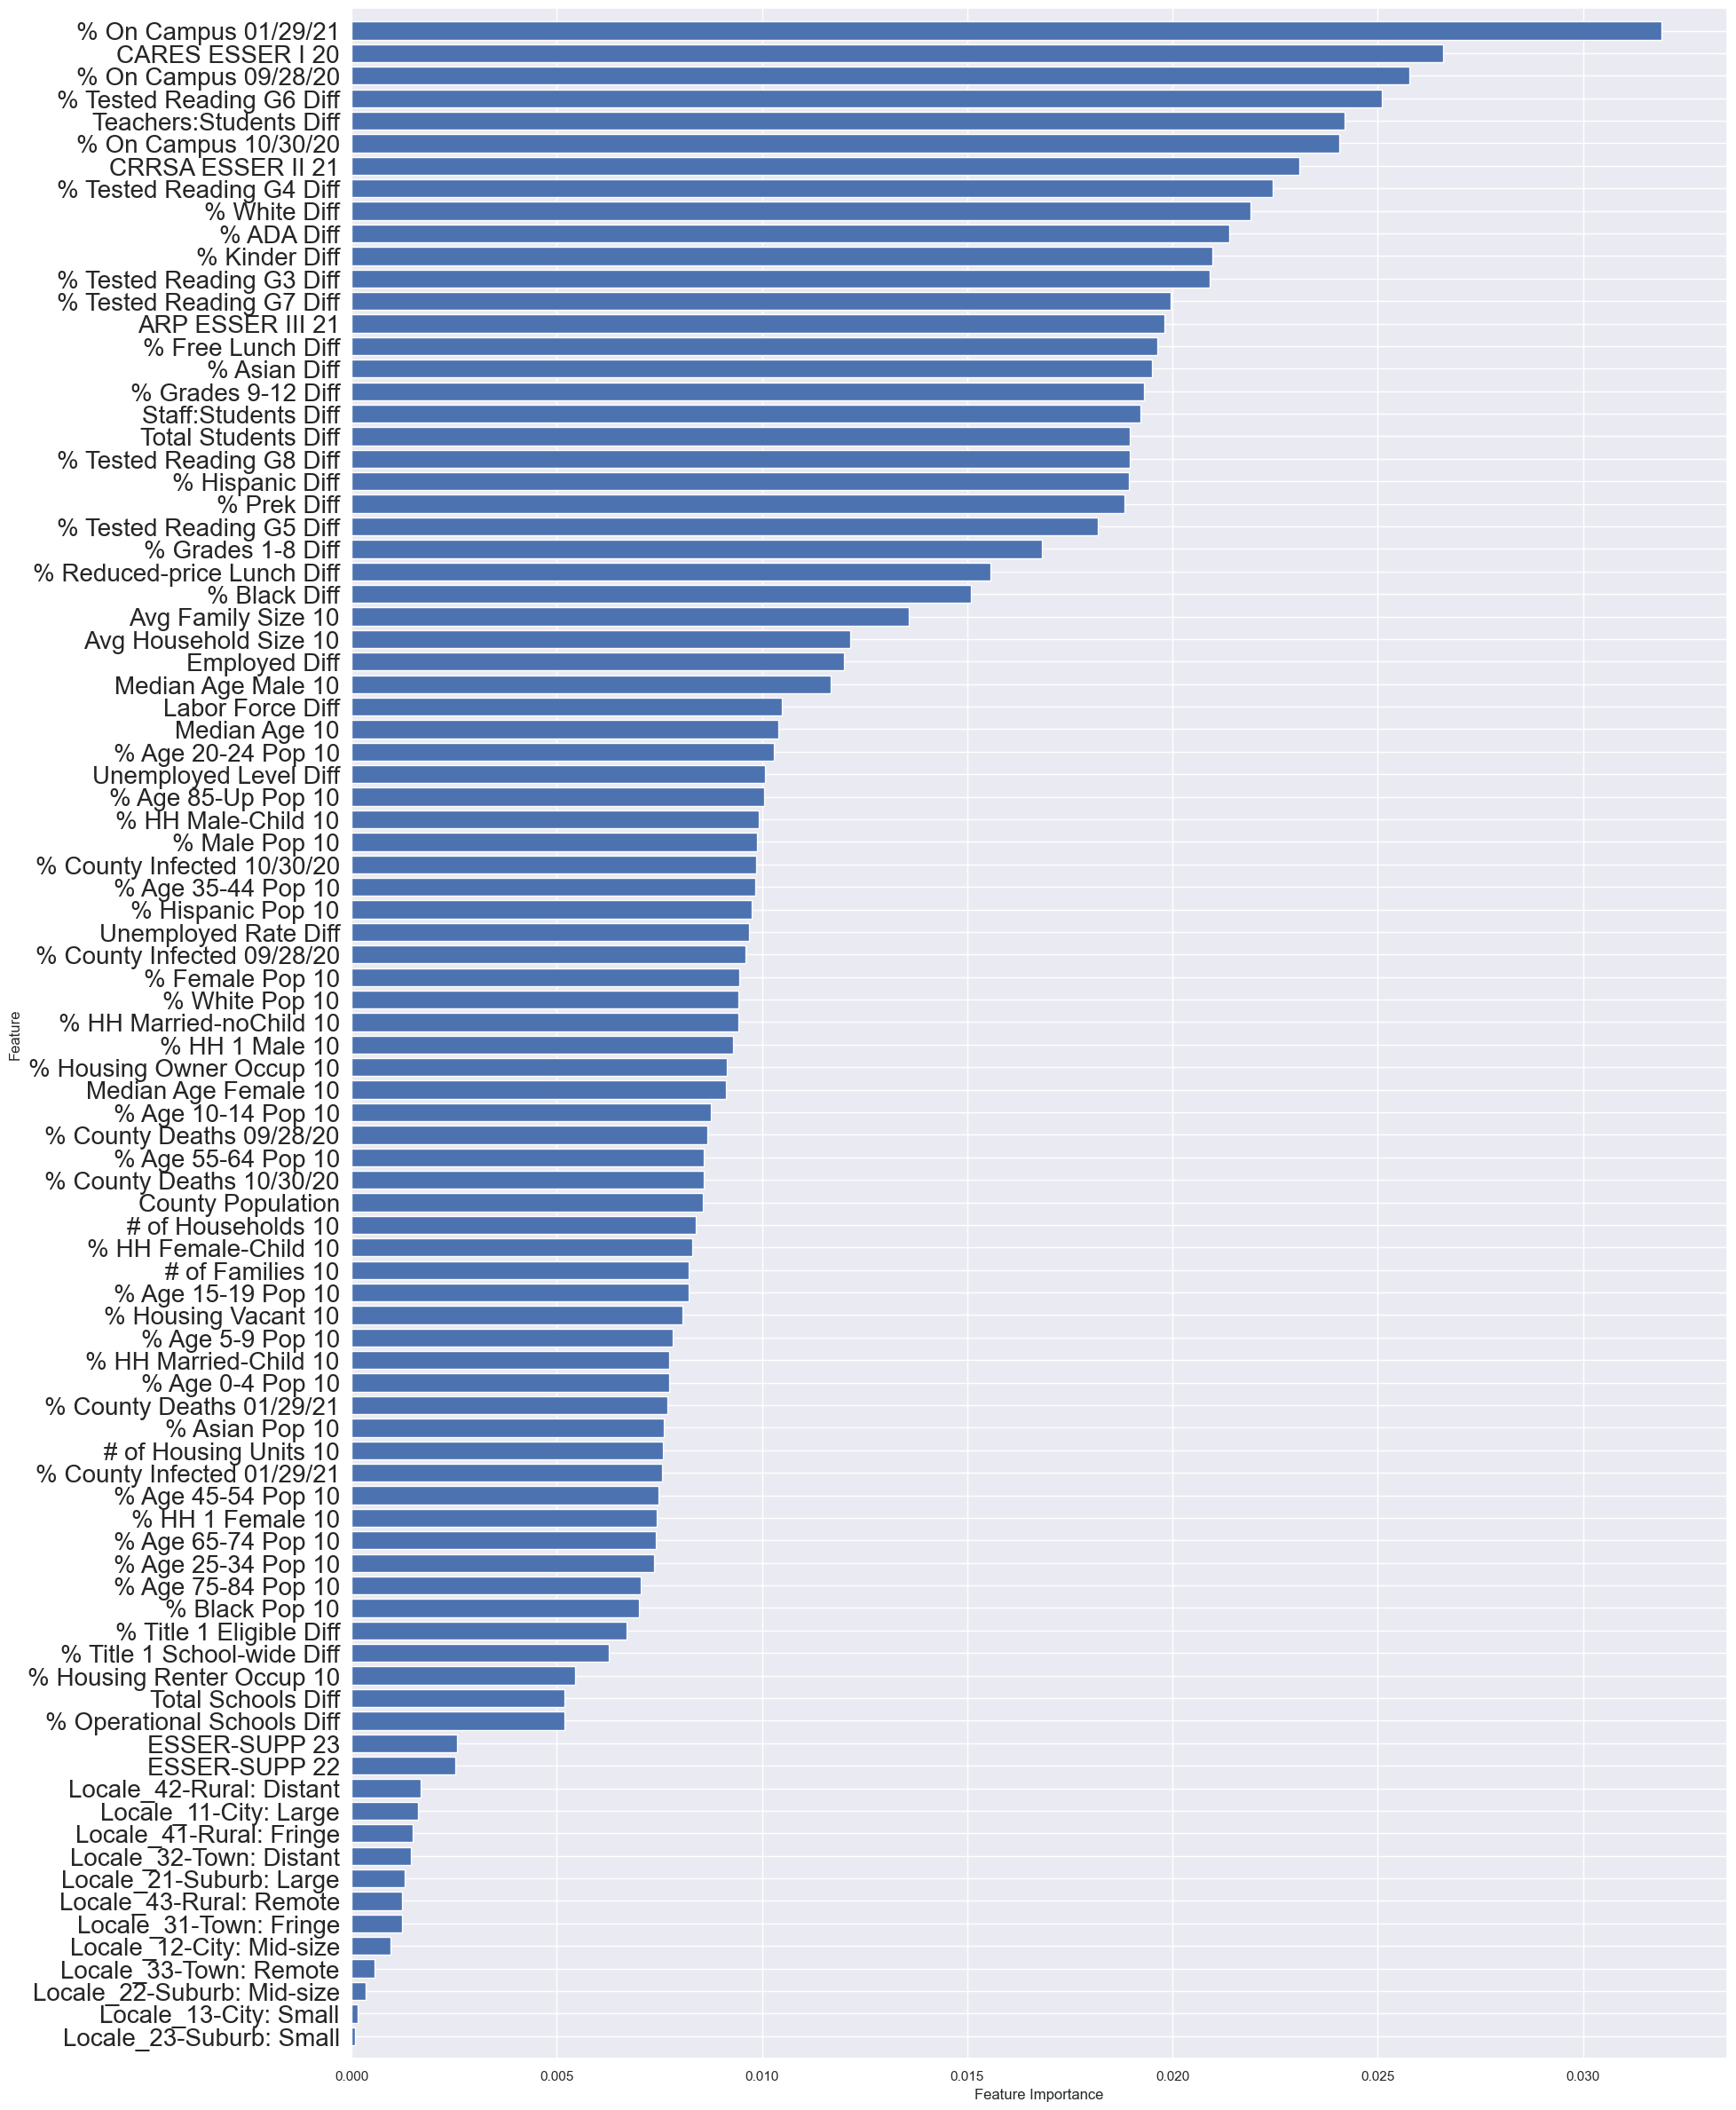

In [11]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,30))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.show()

temp = pd.DataFrame({'feature': columns, 
                        'method': 'Feature Importance',
                        'model': 'Random Forest', 
                        'importance': importances})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Random Forest

Train Score: 1.00
Test Score: 0.53


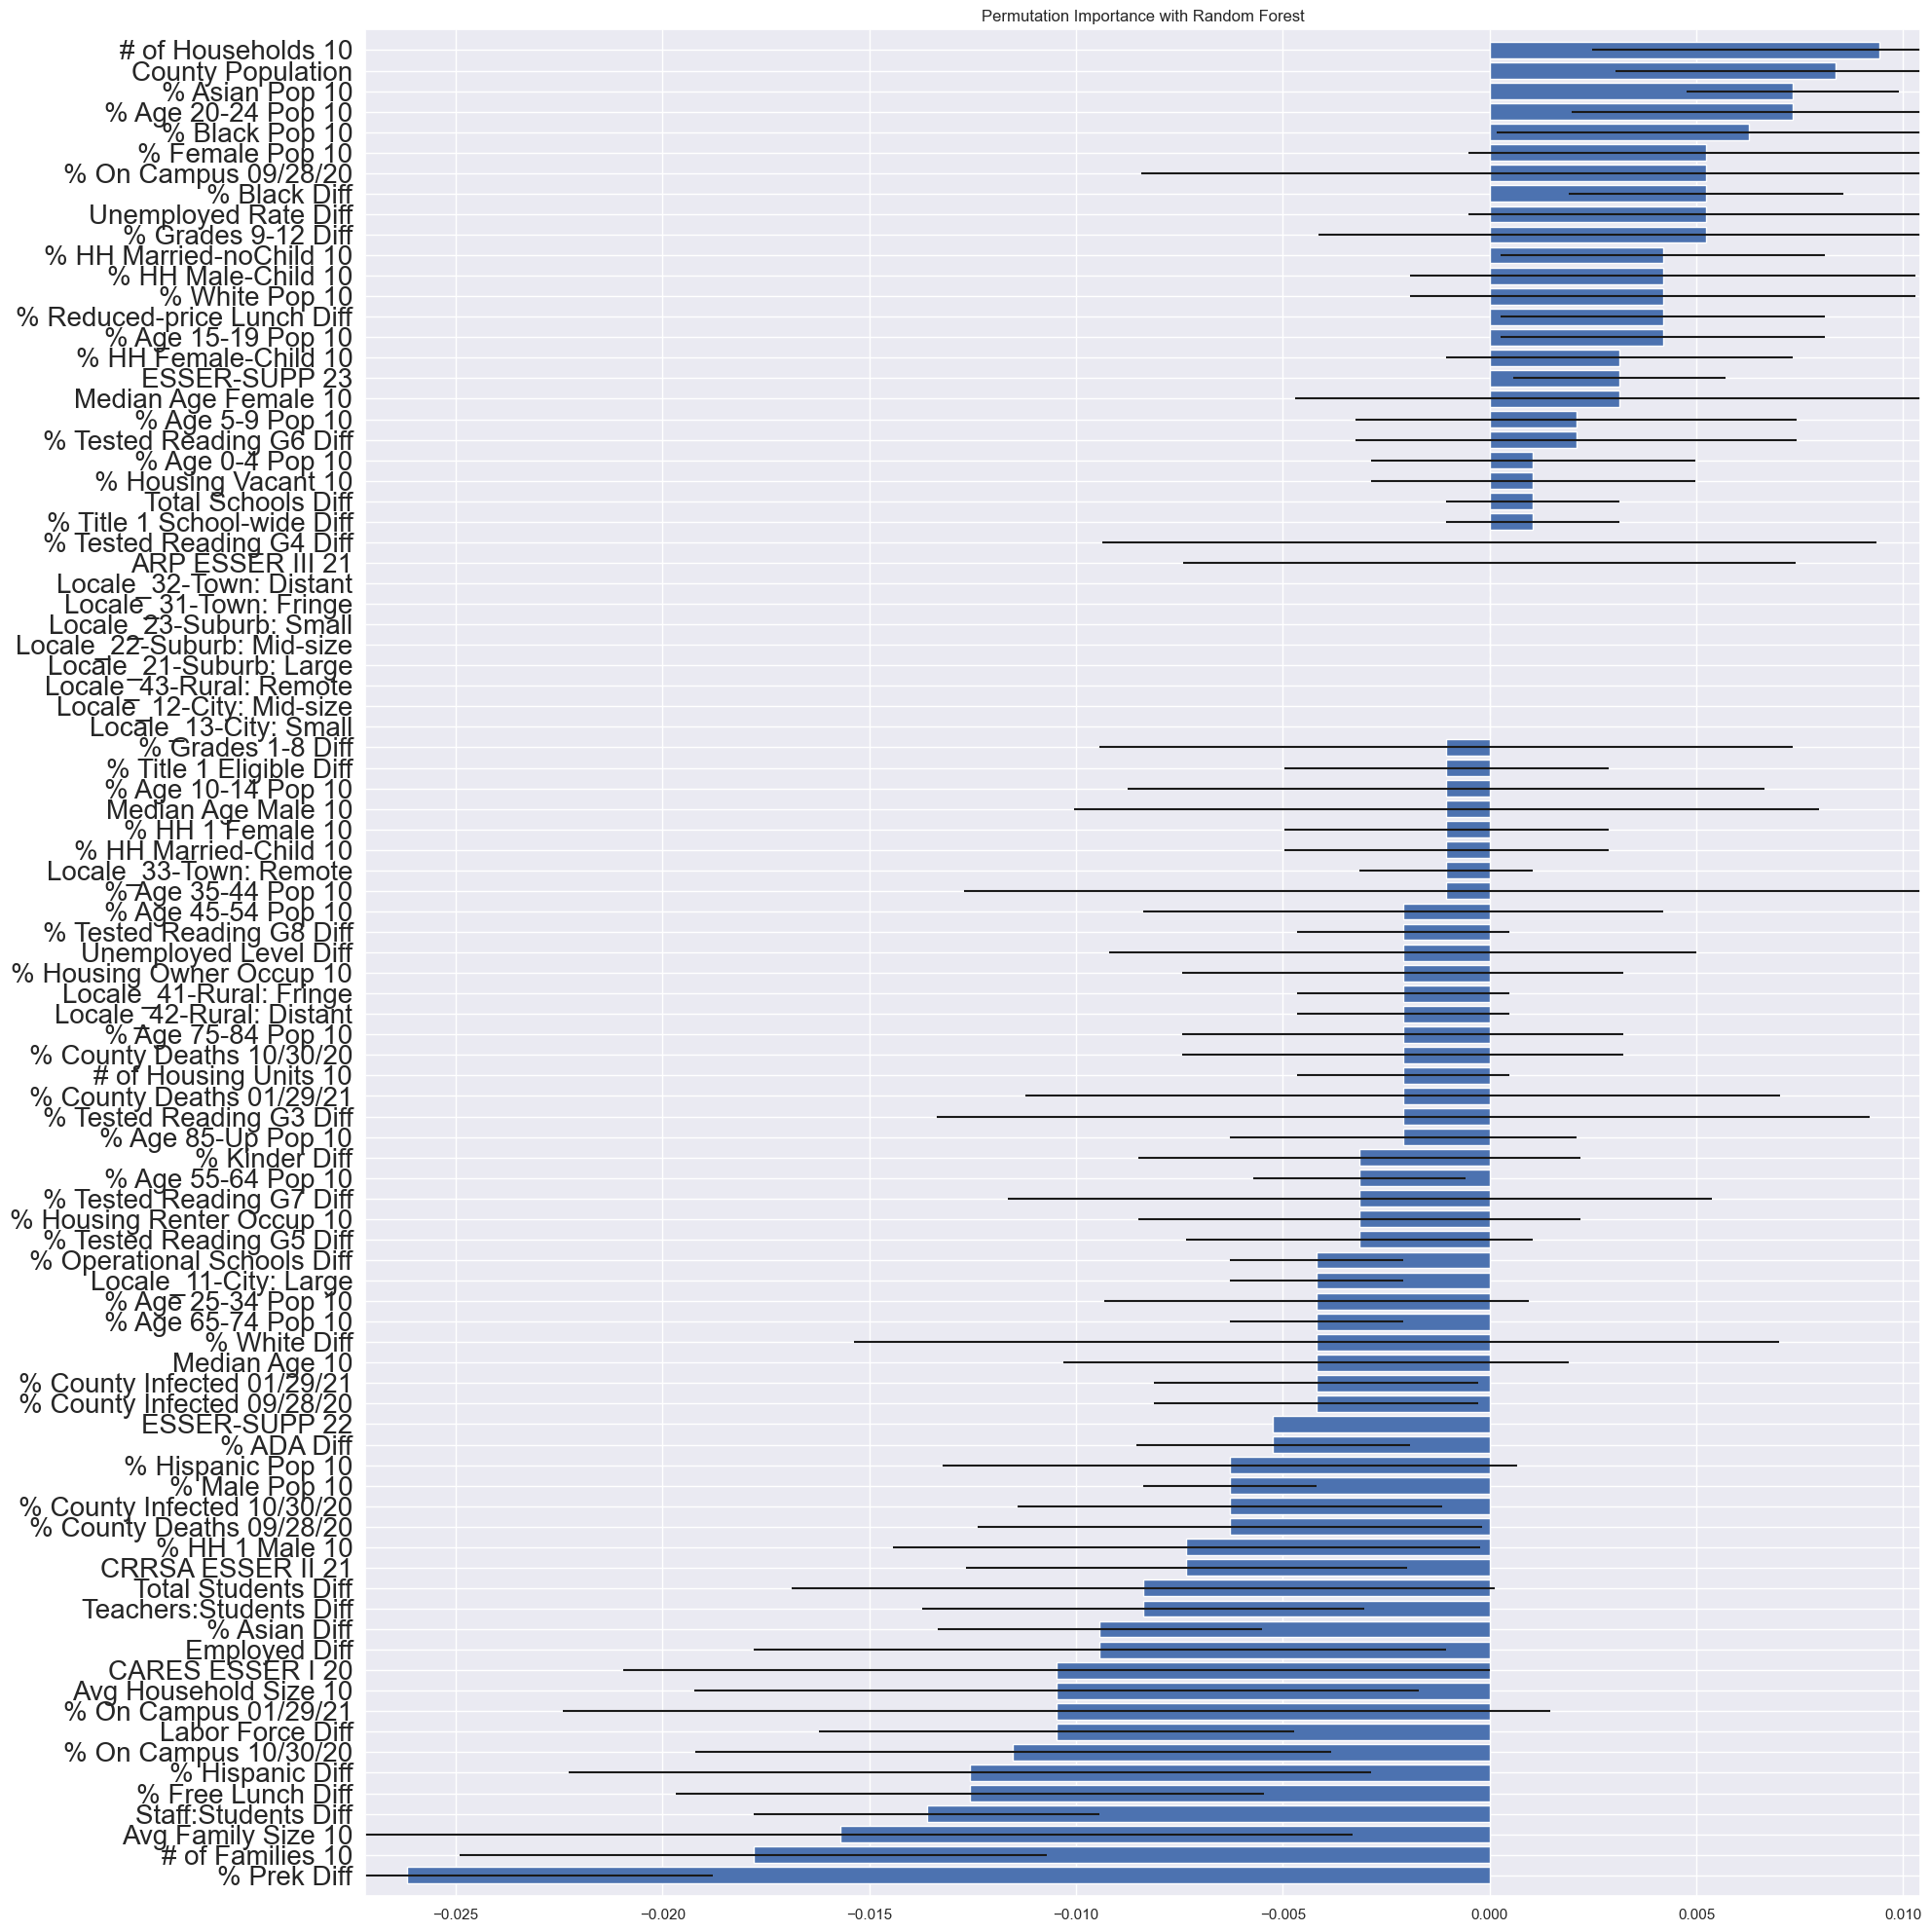

CPU times: user 2.67 s, sys: 510 ms, total: 3.18 s
Wall time: 4.94 s


In [12]:
%%time
from sklearn.inspection import permutation_importance

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Random Forest")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Random Forest', 
                     'importance': result['importances_mean']})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Ridge Regression

Train Score: 0.64
Test Score: 0.54


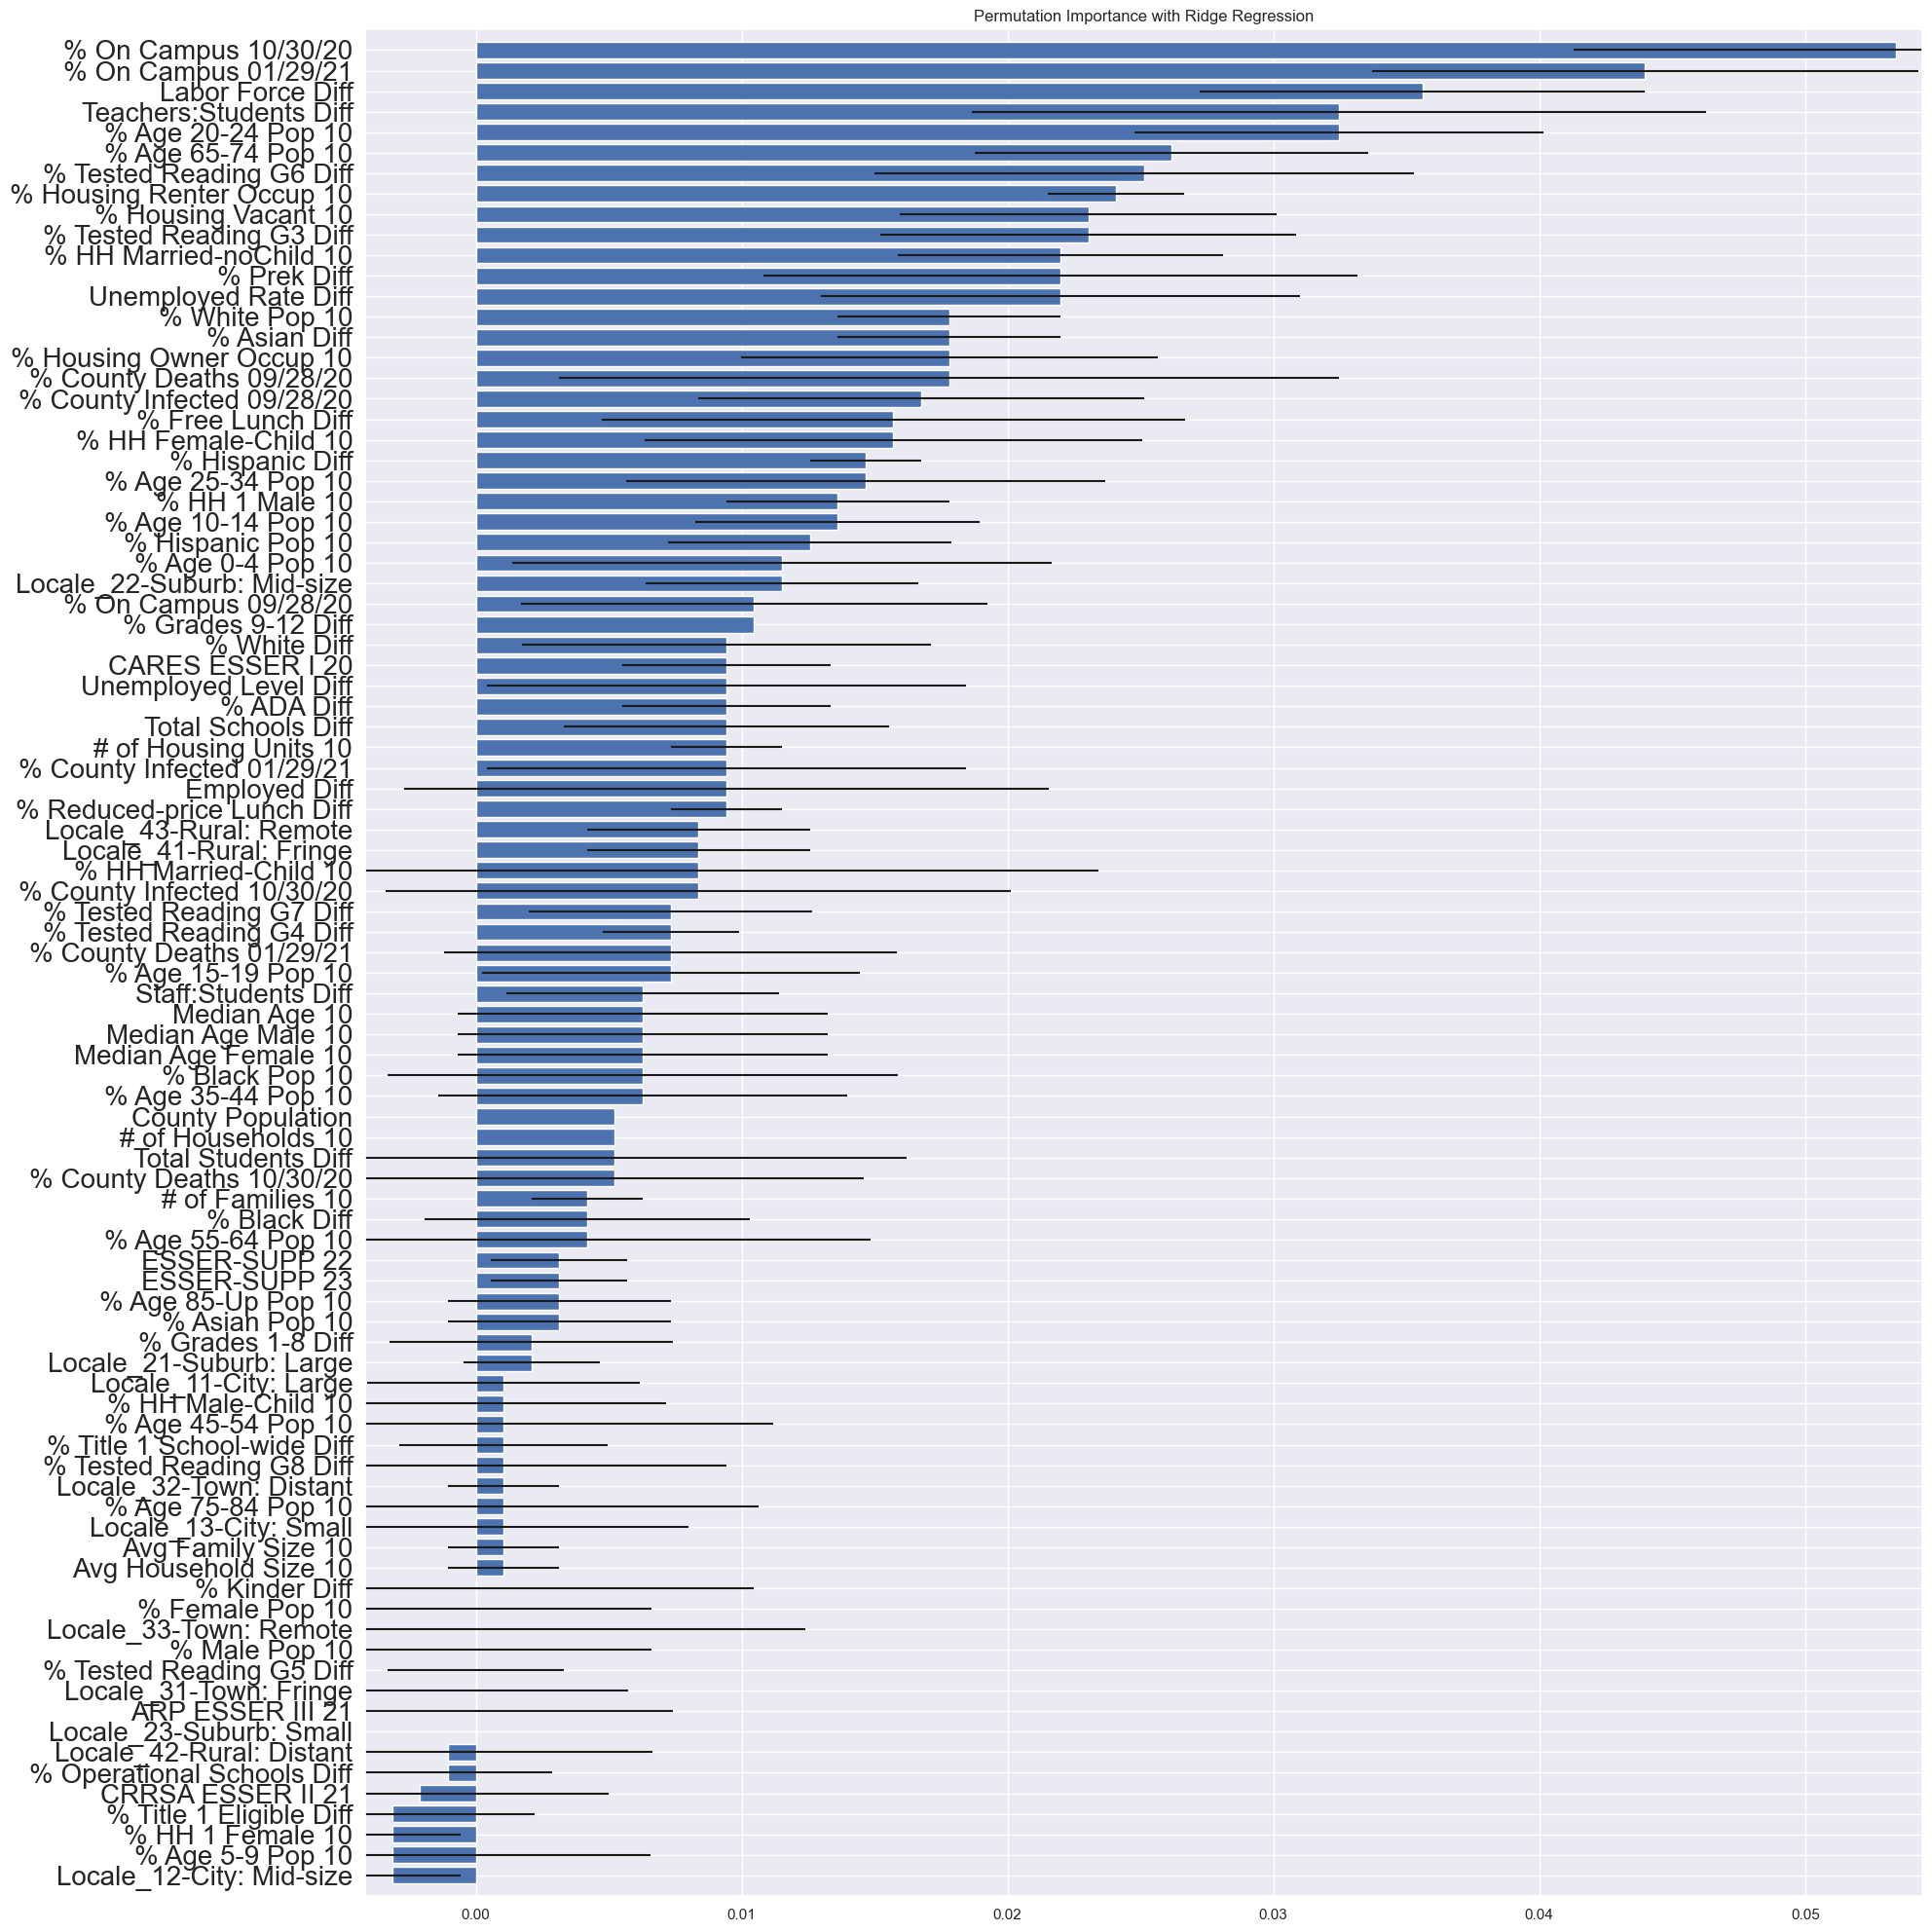

CPU times: user 1.22 s, sys: 184 ms, total: 1.41 s
Wall time: 1.1 s


In [13]:
%%time
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Ridge Regression")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Ridge', 
                     'importance': result['importances_mean']})
results = pd.concat([results, temp], ignore_index=True)

### Recursive Feature Elimination(RFE) ###
with Ridge Regression

In [14]:
%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=10, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected: ', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Ridge', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
Train Score: 0.65
Test Score: 0.53
n Selected:  5
Selected Feature:  Index(['CARES ESSER I 20', 'CRRSA ESSER II 21', 'ARP ESSER III 21',
       'ESSER-SUPP 23', '% On Campus 10/30/20'],
      dtype='object')


### Recursive Feature Elimination(RFE) ###
with Random Forest

In [15]:
%time
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=5, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Random Forest', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs
Train Score: 1.00
Test Score: 0.53
n Selected: 36
Selected Feature:  Index(['Labor Force Diff', 'Employed Diff', 'Unemployed Level Diff',
       'Median Age Female 10', 'Avg Household Size 10', '# of Families 10',
       'CARES ESSER I 20', 'CRRSA ESSER II 21', 'ARP ESSER III 21',
       '% County Infected 09/28/20', '% On Campus 09/28/20',
       '% On Campus 10/30/20', '% On Campus 01/29/21', '% Male Pop 10',
       '% Age 35-44 Pop 10', '% HH Married-noChild 10', 'Total Students Diff',
       'Teachers:Students Diff', 'Staff:Students Diff', '% Free Lunch Diff',
       '% Reduced-price Lunch Diff', '% Asian Diff', '% Hispanic Diff',
       '% Black Diff', '% White Diff', '% Grades 1-8 Diff',
       '% Grades 9-12 Diff', '% Prek Diff', '% Kinder Diff', '% ADA Diff',
       '% Tested Reading G3 Diff', '% Tested Reading G4 Diff',
       '% Tested Reading G5 Diff', '% Tested Reading G6 Diff',
       '% Tested Reading G7 Diff

### Sequential Feature Selection(SFS) ###
with KNN

In [16]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'KNN', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.74
Test Score: 0.54
n Selected: 45
Selected Feature:  Index(['Employed Diff', 'Unemployed Level Diff', 'Median Age 10',
       'Median Age Male 10', 'Median Age Female 10', '# of Households 10',
       'Avg Household Size 10', '# of Families 10', 'Avg Family Size 10',
       '# of Housing Units 10', 'County Population', 'CARES ESSER I 20',
       'CRRSA ESSER II 21', 'ARP ESSER III 21', 'ESSER-SUPP 22',
       'ESSER-SUPP 23', '% On Campus 09/28/20', '% On Campus 10/30/20',
       '% On Campus 01/29/21', '% Black Pop 10', '% Asian Pop 10',
       '% Age 20-24 Pop 10', '% Age 85-Up Pop 10', 'Total Schools Diff',
       'Total Students Diff', '% Operational Schools Diff',
       '% Title 1 Eligible Diff', 'Staff:Students Diff',
       '% Reduced-price Lunch Diff', '% White Diff', '% Prek Diff',
       '% Tested Reading G4 Diff', '% Tested Reading G7 Diff',
       'Locale_11-City: Large', 'Locale_12-City: Mid-size',
       'Locale_13-City: Small', 'Locale_21-Suburb: Large',

### Sequential Feature Selection(SFS) ###
with Ridge Regression

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'Ridge', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.64
Test Score: 0.54
n Selected: 45
Selected Feature:  Index(['Labor Force Diff', 'CARES ESSER I 20', 'CRRSA ESSER II 21',
       'ARP ESSER III 21', 'ESSER-SUPP 22', 'ESSER-SUPP 23',
       '% County Infected 01/29/21', '% On Campus 09/28/20',
       '% On Campus 01/29/21', '% Male Pop 10', '% Female Pop 10',
       '% Age 5-9 Pop 10', '% Age 15-19 Pop 10', '% Age 20-24 Pop 10',
       '% Age 55-64 Pop 10', '% Age 65-74 Pop 10', '% HH 1 Male 10',
       '% HH Male-Child 10', '% Housing Vacant 10', '% Housing Owner Occup 10',
       '% Housing Renter Occup 10', 'Total Schools Diff',
       '% Operational Schools Diff', '% Title 1 School-wide Diff',
       '% Title 1 Eligible Diff', '% Free Lunch Diff',
       '% Reduced-price Lunch Diff', '% Black Diff', '% Grades 1-8 Diff',
       '% Grades 9-12 Diff', '% Prek Diff', '% Kinder Diff', '% ADA Diff',
       '% Tested Reading G3 Diff', '% Tested Reading G4 Diff',
       '% Tested Reading G5 Diff', '% Tested Reading G6 Diff',

### Result: Number of Feature Selected ###

In [18]:
results['selected'] = results['importance'].apply(lambda x: 1 if x > 0 else 0)

th_quantile=0.5
th_rf = results[results['method'] == 'Feature Importance']['importance'].quantile(th_quantile)
print('Threshold for Random Forest Feature Importance is {:0.4f} at {:0.0f}th percentile'.format(th_rf, th_quantile*100))
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'Feature Importance') & (x.importance < th_rf))
                                                 else x.selected, axis=1)
              
results['Method'] = results.apply(lambda x: 'Variance Threshold' if x.method == 'Variance Threshold'
                                                                 else str(x.method) + " - " + str(x.model), axis=1)

Threshold for Random Forest Feature Importance is 0.0094 at 50th percentile


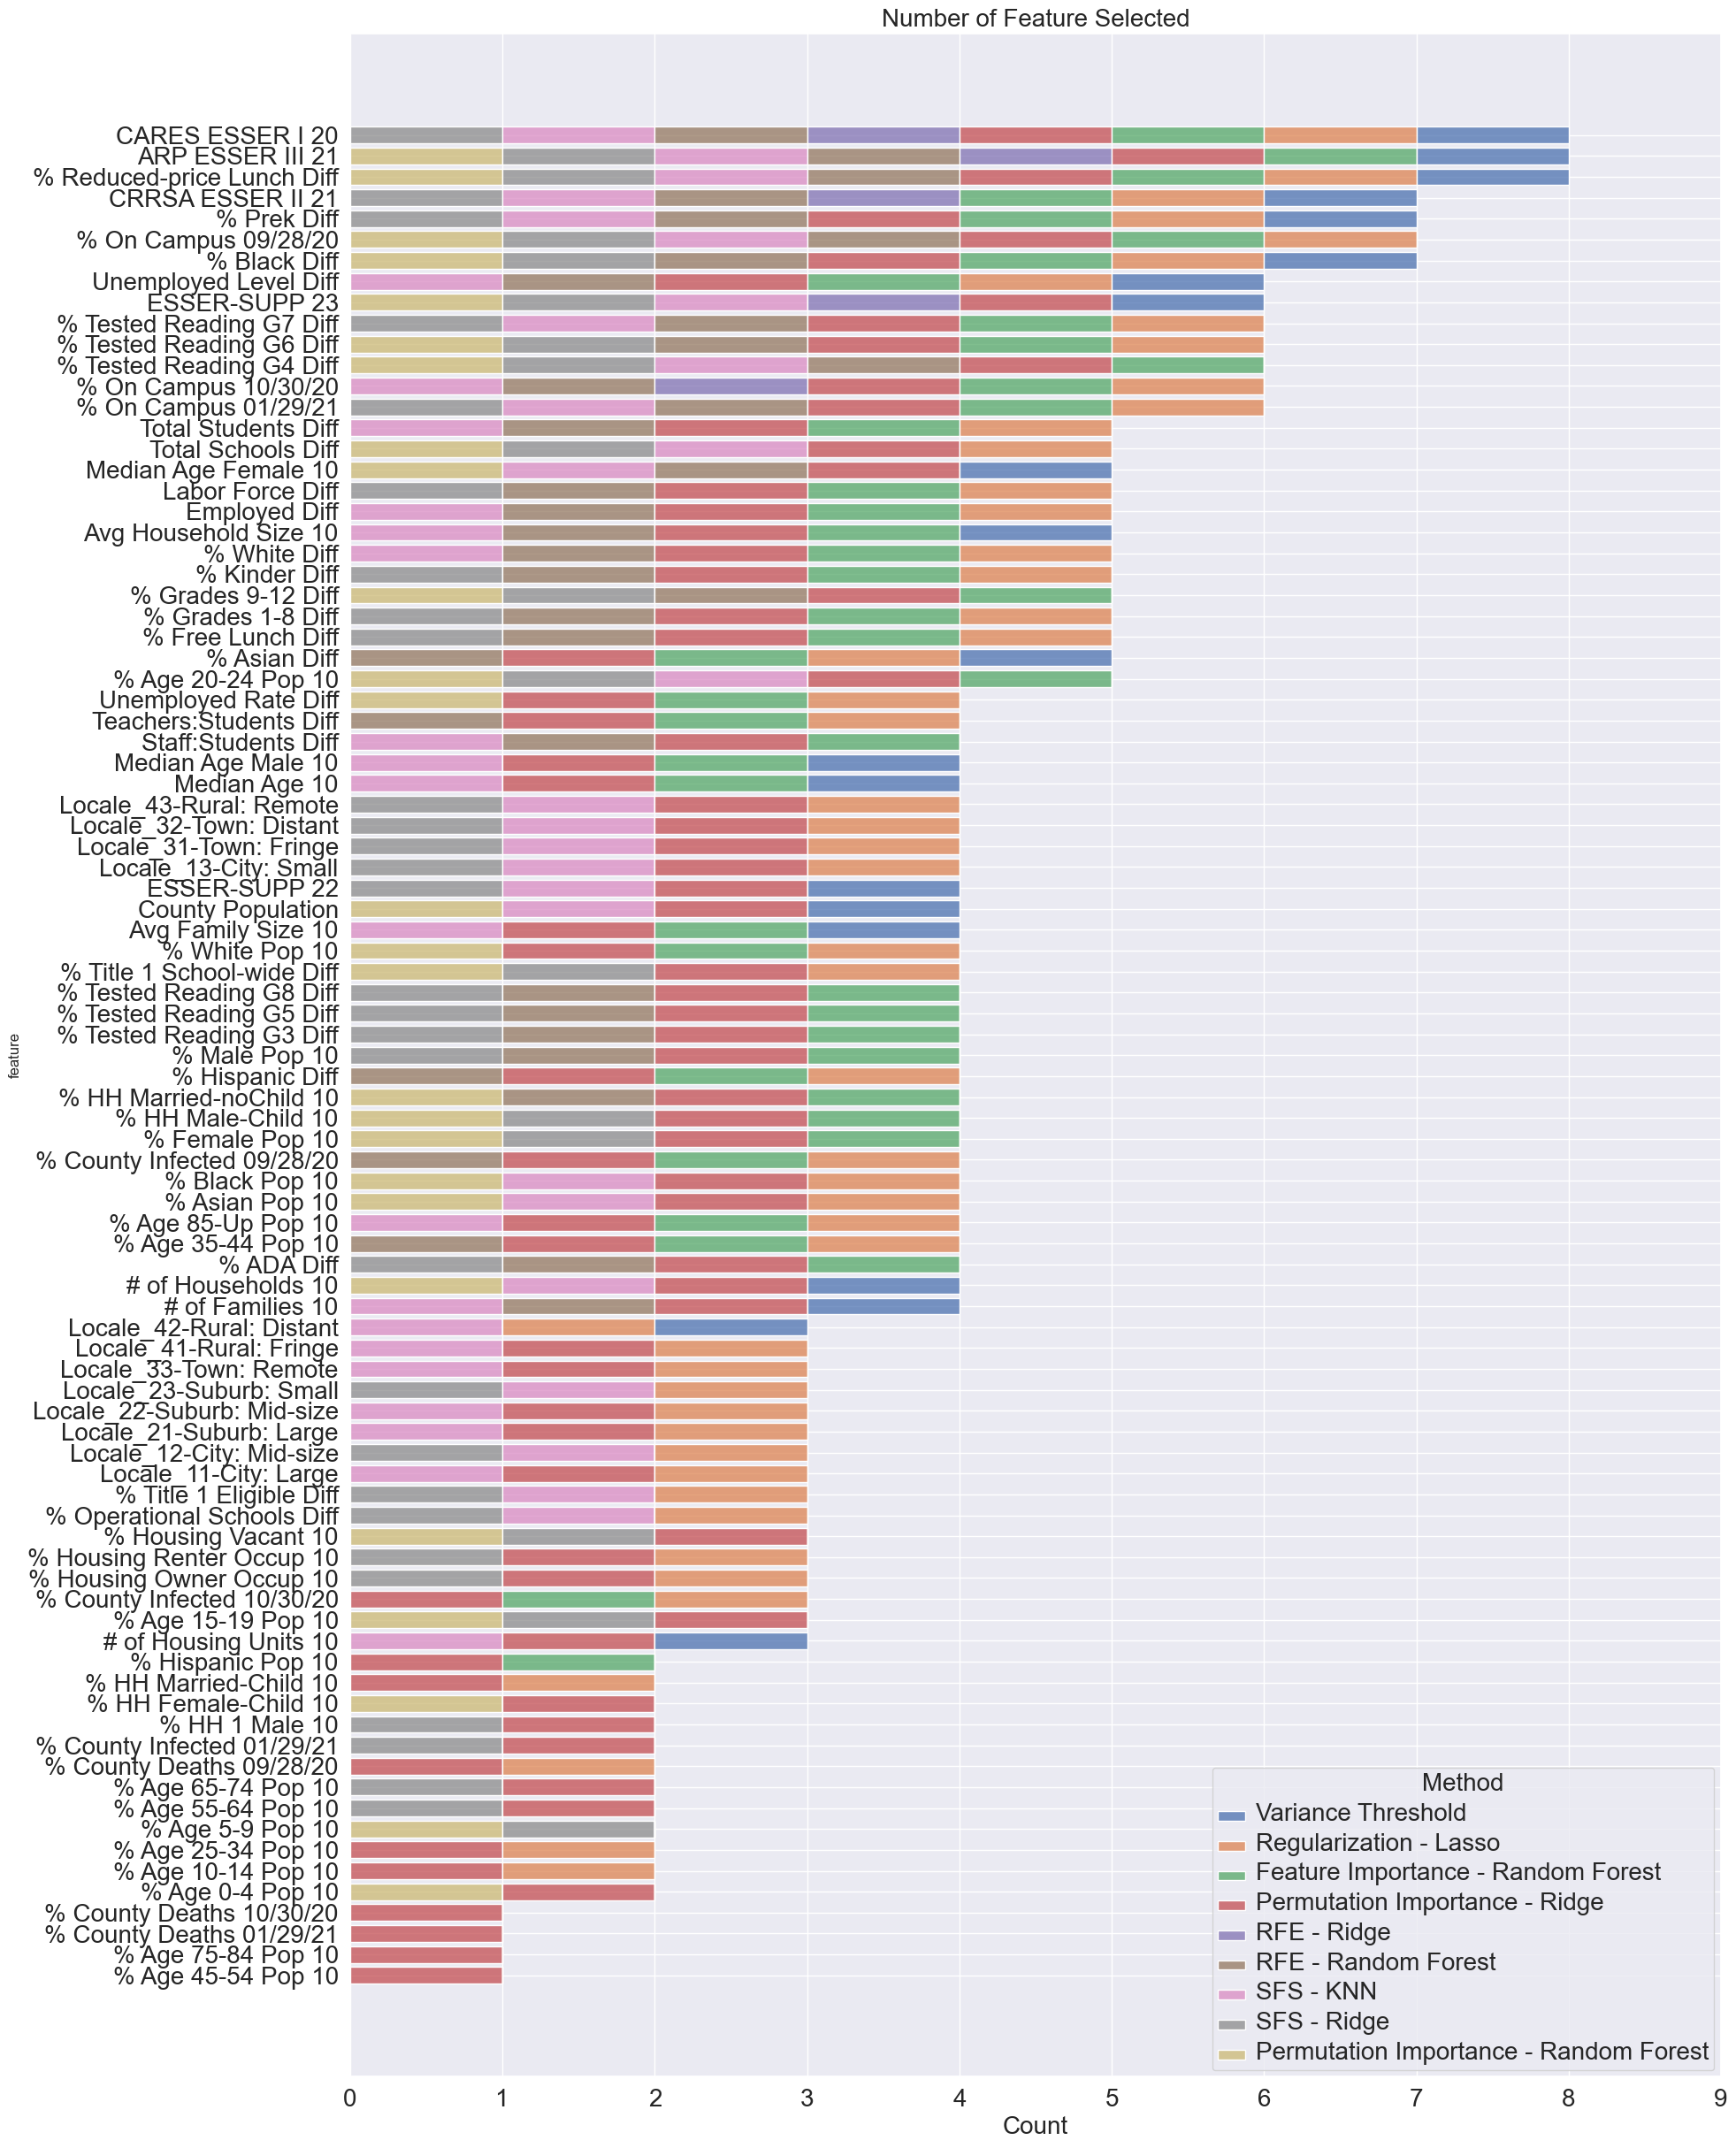

In [19]:
sns.set(rc={'figure.figsize':(20,30)})

features_selected = results[results['selected'] == 1].copy()
features_selected['counts']=features_selected.groupby('feature').transform(lambda x: x.sum())['selected']
features_selected = features_selected.sort_values(by=['counts', 'feature'], ascending=False)

g = sns.histplot(data=features_selected, y='feature', hue='Method', multiple='stack', shrink=0.8, legend=True)
plt.title('Number of Feature Selected', size=20)
plt.xlabel('Count', size=20)
plt.xticks(range(len(features_selected['Method'].unique())+1), list(range(len(features_selected['Method'].unique())+1)), size=20)
plt.yticks(range(len(features_selected.feature.unique())), features_selected.feature.unique(), size=20)
# plt.legend(fontsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='20')
plt.setp(g.get_legend().get_title(), fontsize='20') 
plt.show()

In [20]:
features_selected2 = features_selected.groupby(['feature'], as_index=False).agg({'counts': 'count'})
features_selected2 = features_selected2.sort_values(by=['counts'], ascending=False)
features_selected2[:20]

,feature,counts
47,% Reduced-price Lunch Diff,8
58,ARP ESSER III 21,8
61,CARES ESSER I 20,8
62,CRRSA ESSER II 21,7
18,% Black Diff,7
46,% Prek Diff,7
43,% On Campus 09/28/20,7
44,% On Campus 10/30/20,6
42,% On Campus 01/29/21,6
87,Unemployed Level Diff,6


In [21]:
top7_features = features_selected2.head(7)['feature'].to_list()
top7_features

['% Reduced-price Lunch Diff',
 'ARP ESSER III 21',
 'CARES ESSER I 20',
 'CRRSA ESSER II 21',
 '% Black Diff',
 '% Prek Diff',
 '% On Campus 09/28/20']

In [22]:
df[['District #', 'County #'] + top7_features]

,District #,County #,% Reduced-price Lunch Diff,ARP ESSER III 21,CARES ESSER I 20,CRRSA ESSER II 21,% Black Diff,% Prek Diff,% On Campus 09/28/20
0,57816,48113.0,0.191796,3855200.0,504727.0,1716028.0,0.001747,-0.389387,0.414743
1,57829,48113.0,0.117883,4923202.0,486940.0,2191417.0,-0.178351,0.078952,0.363014
2,109901,48217.0,-0.326034,200420.0,24677.0,89211.0,1.021898,-0.107986,0.923611
3,95901,48189.0,-0.060524,1228930.0,148782.0,547022.0,0.497942,0.274510,0.937733
4,221901,48441.0,0.044077,42084907.0,3970117.0,18732848.0,-0.027114,-0.047169,0.825230
...,...,...,...,...,...,...,...,...,...
950,250905,48499.0,-0.060040,994639.0,76512.0,442734.0,0.000000,-0.072190,0.885559
951,71905,48141.0,-1.000000,139675292.0,14302544.0,62172314.0,0.010331,-0.456438,0.000000
952,253901,48505.0,0.000000,16698810.0,1538030.0,7432980.0,-1.000000,-0.337356,0.019518
953,3906,48005.0,-0.142857,1178447.0,100200.0,524551.0,-0.400000,0.200000,0.880795


In [37]:
features_selected.to_csv('Features_Selected1_Reading.csv', index=False)

In [23]:
features_selected2.to_csv('Features_Selected_Reading.csv', index=False)

### Evaluating sets of features ###
with models: Lasso, Ridge, Random Forest, Gradient Boosting, KNN

In [24]:
def model_report_1(estimator, name):
    df_report = pd.DataFrame()
    
    for count in range(features_selected['counts'].min(), features_selected['counts'].max()+1):
        features = features_selected[features_selected['counts'] >= count]['feature'].unique().tolist()
        index = np.argwhere(np.isin(columns, features))
        X_train2 = X_train[:, index.flatten()]
        X_test2 = X_test[:, index.flatten()]
       
        estimator.fit(X_train2, y_train)
        y_pred = estimator.predict(X_test2)
        temp = {'model': name,
                'n Selected': int(index.shape[0]),
                'type': 'by counts',
                'Counts': count,
                'Method': np.nan,
                'Train Accuracy': estimator.score(X_train2, y_train),
                'Test Accuracy': estimator.score(X_test2, y_test),
                'MCC': matthews_corrcoef(y_test, y_pred),
                'F1': f1_score(y_test, y_pred, average='weighted'),
                'features': features}
        df_report = pd.concat([df_report, pd.DataFrame([temp])], ignore_index=True)
    return df_report

def model_report_2(estimator, name):
    df_report = pd.DataFrame()
    
    for method in features_selected['Method'].unique():
        features = features_selected[features_selected['Method'] == method]['feature'].unique().tolist()
        index = np.argwhere(np.isin(columns, features))
        X_train2 = X_train[:, index.flatten()]
        X_test2 = X_test[:, index.flatten()]
       
        estimator.fit(X_train2, y_train)
        y_pred = estimator.predict(X_test2)
        temp = {'model': name,
                'n Selected': int(index.shape[0]),
                'type': 'by methods',
                'Counts': 'n/a',
                'Method': method,
                'Train Accuracy': estimator.score(X_train2, y_train),
                'Test Accuracy': estimator.score(X_test2, y_test),
                'MCC': matthews_corrcoef(y_test, y_pred),
                'F1': f1_score(y_test, y_pred, average='weighted'),
                'features': features}
        df_report = pd.concat([df_report, pd.DataFrame([temp])], ignore_index=True)
    return df_report

Lasso

In [25]:
report = pd.DataFrame()

estimator = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, multi_class='ovr', random_state=random_state)

temp = model_report_1(estimator, 'Lasso')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Lasso')
report = pd.concat([report, temp], ignore_index=True)

Ridge

In [26]:
estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, multi_class='ovr', random_state=random_state)

temp = model_report_1(estimator, 'Ridge')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Ridge')
report = pd.concat([report, temp], ignore_index=True)

Random Forest

In [27]:
estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)

temp = model_report_1(estimator, 'Random Forest')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Random Forest')
report = pd.concat([report, temp], ignore_index=True)

Grandient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(n_estimators=100, random_state=random_state)

temp = model_report_1(estimator, 'Gradient Boosting')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Grandient Boosting')
report = pd.concat([report, temp], ignore_index=True)

KNN

In [29]:
estimator = KNeighborsClassifier(n_neighbors=3)

temp = model_report_1(estimator, 'KNN')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'KNN')
report = pd.concat([report, temp], ignore_index=True)

In [30]:
report2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = report[['model', 'n Selected', 'type', 'Method'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    report2 = pd.concat([report2, temp], ignore_index=True)
report2=report2.astype({'n Selected': 'int32'})

**Evaluating Feature Set by Counts Selected**

In [31]:
for count in features_selected2['counts'].unique():
    print('n Selected by {} methods: {}'.format(count, (features_selected2[features_selected2['counts'] >= count].shape[0])))

n Selected by 8 methods: 3
n Selected by 7 methods: 7
n Selected by 6 methods: 14
n Selected by 5 methods: 27
n Selected by 4 methods: 57
n Selected by 3 methods: 73
n Selected by 2 methods: 85
n Selected by 1 methods: 89


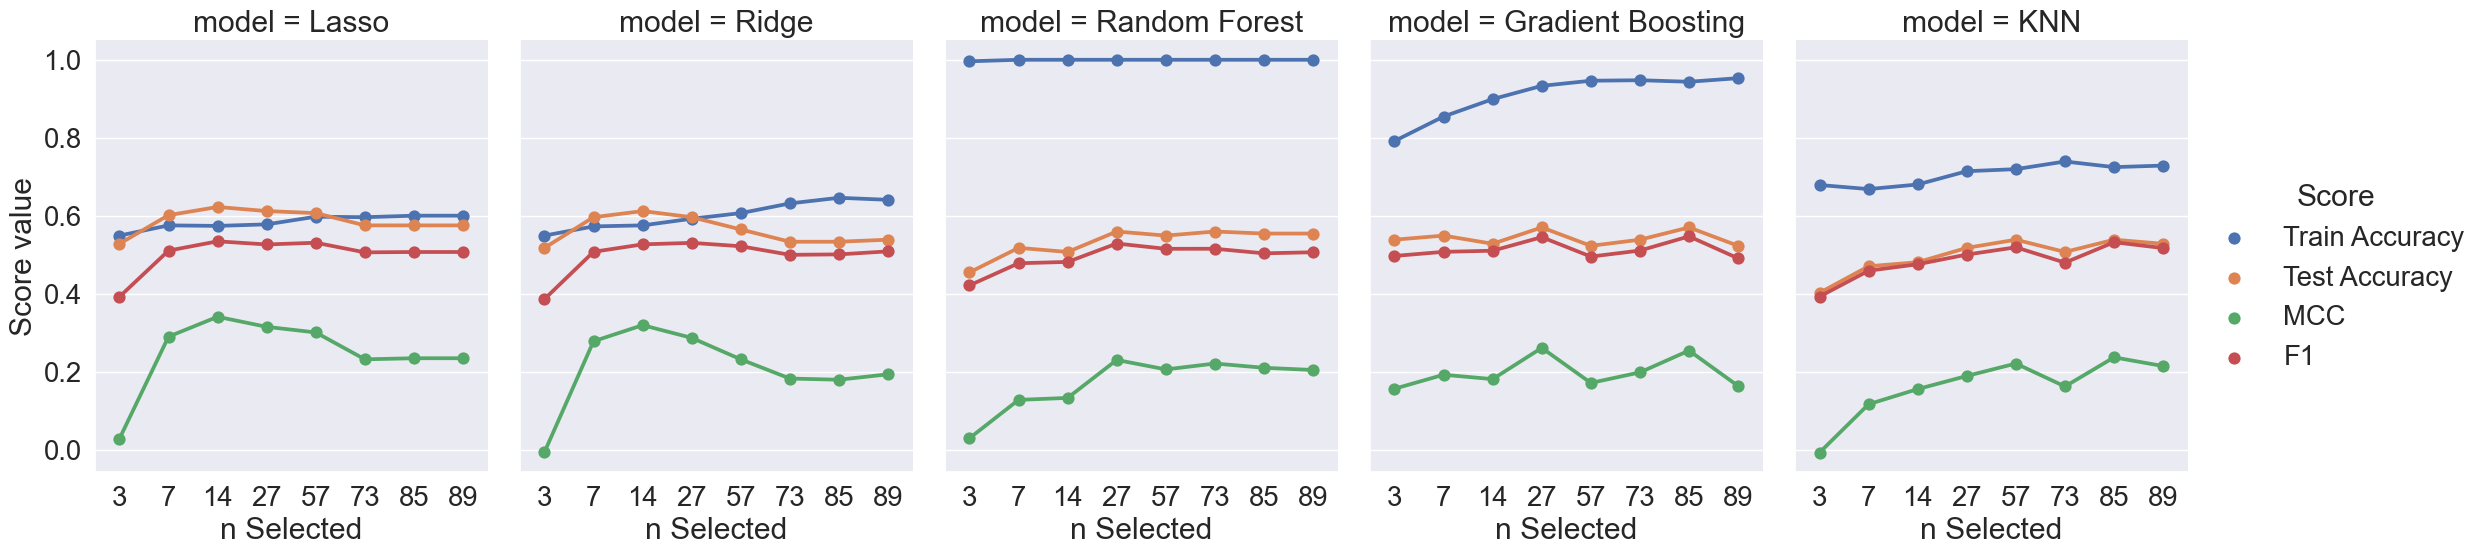

In [32]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="model",
                capsize=.2, palette="deep", height=6, aspect=.75,
                kind="point", data=report2[report2['type']=='by counts'])
# g.despine(left=True)
plt.show()

**Evaluating Feature Set by Selection Methods**

In [33]:
report2[report2['type']=='by methods'].groupby(['Method'], as_index=False).agg({'n Selected': 'max'}).sort_values(by=['n Selected'])

,Method,n Selected
4,RFE - Ridge,5
8,Variance Threshold,20
1,Permutation Importance - Random Forest,26
3,RFE - Random Forest,36
0,Feature Importance - Random Forest,45
6,SFS - KNN,45
7,SFS - Ridge,45
5,Regularization - Lasso,51
2,Permutation Importance - Ridge,82


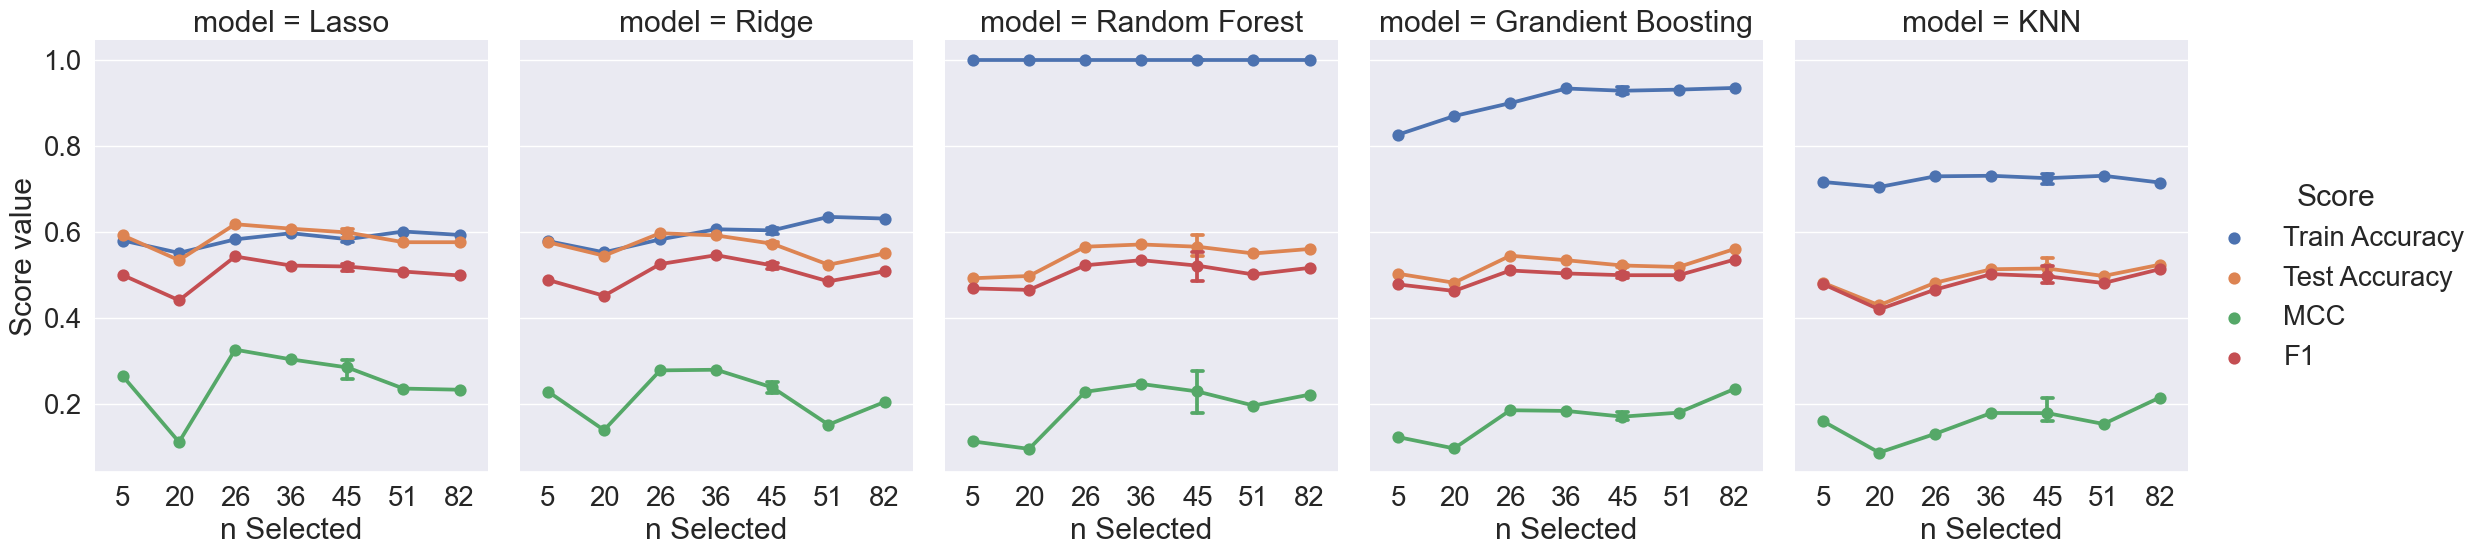

In [34]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="model",
                capsize=.2, palette="deep", height=6, aspect=.75,
                kind="point", data=report2[report2['type']=='by methods'])
g.despine(left=True)
plt.show()

In [35]:
report.sort_values(by=['MCC', 'F1'], ascending=False).head(5)

,model,n Selected,type,Counts,Method,Train Accuracy,Test Accuracy,MCC,F1,features
5,Lasso,14,by counts,6,NaN,0.574607,0.623037,0.341848,0.535087,"[CARES ESSER I 20, ARP ESSER III 21, % Reduced..."
16,Lasso,26,by methods,n/a,Permutation Importance - Random Forest,0.582461,0.617801,0.326122,0.542740,"[ARP ESSER III 21, % Reduced-price Lunch Diff,..."
22,Ridge,14,by counts,6,NaN,0.575916,0.612565,0.320403,0.527300,"[CARES ESSER I 20, ARP ESSER III 21, % Reduced..."
4,Lasso,27,by counts,5,NaN,0.578534,0.612565,0.316089,0.527049,"[CARES ESSER I 20, ARP ESSER III 21, % Reduced..."
13,Lasso,36,by methods,n/a,RFE - Random Forest,0.596859,0.607330,0.303467,0.521577,"[CARES ESSER I 20, ARP ESSER III 21, % Reduced..."


In [36]:
report.to_csv('Feature_Selection_Reading_Report.csv', index=False)